### DNN

### Import libraries

In [3]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lynxx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lynxx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Preprocessing module

In [5]:
# Load the data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [6]:
# Text preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters and spaces
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Applying preprocessing
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])

# Prepare padded sequences for titles and descriptions
max_length_titles = max([len(x.split()) for x in train_df['Title']])
max_length_descriptions = max([len(x.split()) for x in train_df['Description']])

X_train_title_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Title']), maxlen=max_length_titles)
X_test_title_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Title']), maxlen=max_length_titles)

X_train_description_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Description']), maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Description']), maxlen=max_length_descriptions)

# Prepare labels
y_train = train_df['Class Index'].values - 1  # Adjust indices to [0, 1, 2, 3]
y_test = test_df['Class Index'].values - 1

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)

### Bacic training module

In [8]:
# Build baseline model
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = embedding_layer(title_input)
title_flatten = Flatten()(title_embedding)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = embedding_layer(description_input)
description_flatten = Flatten()(description_embedding)

merged = Concatenate()([title_flatten, description_flatten])

dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

model = Model(inputs=[title_input, description_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train baseline model
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, 
          epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/5


C:\Users\lynxx\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'description_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 49s 14ms/step - accuracy: 0.7961 - loss: 0.5862 - val_accuracy: 0.8765 - val_loss: 0.3504
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - accuracy: 0.8869 - loss: 0.3283 - val_accuracy: 0.8777 - val_loss: 0.3415
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.8967 - loss: 0.2976 - val_accuracy: 0.8783 - val_loss: 0.3388
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.9015 - loss: 0.2844 - val_accuracy: 0.8804 - val_loss: 0.3366
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.9074 - loss: 0.2666 - val_accuracy: 0.8827 - val_loss: 0.3334


### Testing Module 1

 34/238 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

C:\Users\lynxx\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'description_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Baseline Test Accuracy: 0.8826
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1900
           1       0.94      0.96      0.95      1900
           2       0.85      0.83      0.84      1900
           3       0.86      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



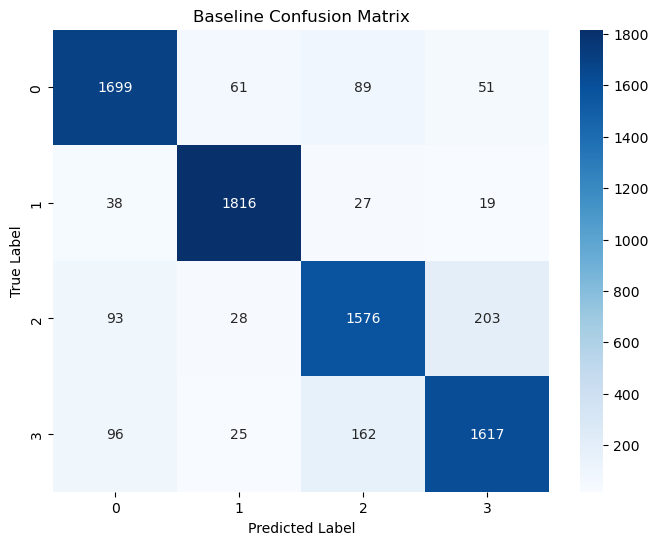

In [10]:
# Test the baseline model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

baseline_accuracy = (y_pred_classes == y_test).mean()
print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Confusion Matrix')
plt.show()

### Hyperparameter selection module

In [12]:
def model_builder(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_units = trial.suggest_int('num_units', 64, 512)

    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = embedding_layer(title_input)
    title_flatten = Flatten()(title_embedding)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = embedding_layer(description_input)
    description_flatten = Flatten()(description_embedding)

    merged = Concatenate()([title_flatten, description_flatten])
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    _, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best Trial:", study.best_trial)

[I 2024-10-29 12:57:48,614] A new study created in memory with name: no-name-950aa91a-53d0-4e0e-b85e-0757a8e31946


Epoch 1/3


C:\Users\lynxx\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'description_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - accuracy: 0.8542 - loss: 0.4150 - val_accuracy: 0.8707 - val_loss: 0.3551
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 74s 22ms/step - accuracy: 0.8968 - loss: 0.2927 - val_accuracy: 0.8684 - val_loss: 0.3588
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 76s 22ms/step - accuracy: 0.9198 - loss: 0.2275 - val_accuracy: 0.8785 - val_loss: 0.3554
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.3527


[I 2024-10-29 13:01:36,752] Trial 0 finished with value: 0.8851315975189209 and parameters: {'dropout_rate': 0.1402102446660728, 'learning_rate': 0.0009190406317623037, 'num_units': 203}. Best is trial 0 with value: 0.8851315975189209.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 109s 32ms/step - accuracy: 0.8301 - loss: 0.4952 - val_accuracy: 0.8747 - val_loss: 0.3505
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 108s 32ms/step - accuracy: 0.8870 - loss: 0.3242 - val_accuracy: 0.8796 - val_loss: 0.3384
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 111s 33ms/step - accuracy: 0.8979 - loss: 0.2944 - val_accuracy: 0.8803 - val_loss: 0.3310
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8820 - loss: 0.3411


[I 2024-10-29 13:07:06,198] Trial 1 finished with value: 0.8840789198875427 and parameters: {'dropout_rate': 0.4227694601937356, 'learning_rate': 5.77483781291114e-05, 'num_units': 297}. Best is trial 0 with value: 0.8851315975189209.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 143s 42ms/step - accuracy: 0.8404 - loss: 0.4814 - val_accuracy: 0.8770 - val_loss: 0.3480
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 139s 41ms/step - accuracy: 0.8905 - loss: 0.3180 - val_accuracy: 0.8794 - val_loss: 0.3348
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 137s 41ms/step - accuracy: 0.9021 - loss: 0.2795 - val_accuracy: 0.8786 - val_loss: 0.3404
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8834 - loss: 0.3371


[I 2024-10-29 13:14:06,565] Trial 2 finished with value: 0.8831579089164734 and parameters: {'dropout_rate': 0.15312765260093808, 'learning_rate': 4.4682977501969075e-05, 'num_units': 385}. Best is trial 0 with value: 0.8851315975189209.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 177s 52ms/step - accuracy: 0.8558 - loss: 0.4209 - val_accuracy: 0.8736 - val_loss: 0.3491
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 171s 51ms/step - accuracy: 0.9001 - loss: 0.2840 - val_accuracy: 0.8822 - val_loss: 0.3236
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 177s 53ms/step - accuracy: 0.9233 - loss: 0.2234 - val_accuracy: 0.8835 - val_loss: 0.3279
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8873 - loss: 0.3291


[I 2024-10-29 13:22:53,073] Trial 3 finished with value: 0.8881579041481018 and parameters: {'dropout_rate': 0.12110768600987176, 'learning_rate': 0.00013918813578086032, 'num_units': 490}. Best is trial 3 with value: 0.8881579041481018.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 163s 48ms/step - accuracy: 0.8529 - loss: 0.4147 - val_accuracy: 0.8722 - val_loss: 0.3498
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 161s 48ms/step - accuracy: 0.8991 - loss: 0.2880 - val_accuracy: 0.8810 - val_loss: 0.3494
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 159s 47ms/step - accuracy: 0.9229 - loss: 0.2197 - val_accuracy: 0.8737 - val_loss: 0.3658
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8772 - loss: 0.3663


[I 2024-10-29 13:30:57,297] Trial 4 finished with value: 0.8799999952316284 and parameters: {'dropout_rate': 0.17553354258451898, 'learning_rate': 0.0009299419437409455, 'num_units': 458}. Best is trial 3 with value: 0.8881579041481018.


Best Trial: FrozenTrial(number=3, state=1, values=[0.8881579041481018], datetime_start=datetime.datetime(2024, 10, 29, 13, 14, 6, 565663), datetime_complete=datetime.datetime(2024, 10, 29, 13, 22, 53, 73488), params={'dropout_rate': 0.12110768600987176, 'learning_rate': 0.00013918813578086032, 'num_units': 490}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=3, value=None)


### Testing module 2

Epoch 1/5


C:\Users\lynxx\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['title_input', 'description_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 177s 52ms/step - accuracy: 0.8545 - loss: 0.4207 - val_accuracy: 0.8797 - val_loss: 0.3328
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 171s 51ms/step - accuracy: 0.9019 - loss: 0.2807 - val_accuracy: 0.8808 - val_loss: 0.3315
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 175s 52ms/step - accuracy: 0.9229 - loss: 0.2217 - val_accuracy: 0.8827 - val_loss: 0.3367
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 173s 51ms/step - accuracy: 0.9445 - loss: 0.1671 - val_accuracy: 0.8790 - val_loss: 0.3560
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 172s 51ms/step - accuracy: 0.9643 - loss: 0.1163 - val_accuracy: 0.8780 - val_loss: 0.3778
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final Test Accuracy: 0.8838
Final Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1900
           1       0.93      0.97      0.95      1900
           2       0.85      0.83      0.84      1900
           3       0.85      0.86  

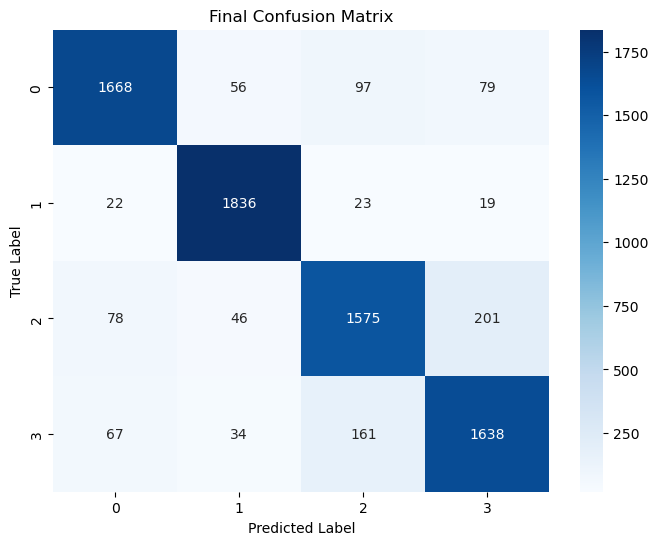

In [14]:
best_trial = study.best_trial
model = model_builder(best_trial)
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Final evaluation
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

final_accuracy = (y_pred_classes == y_test).mean()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print("Final Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix')
plt.show()